In [1]:
# 25 nm - 1550 nm

import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks
###############################################################
#LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/media/leonardo/datam02/Ring Resonator - Leonardo Pessôa/Ring-Resonator/Tutorial/')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('D:/AAAAAAAArquivos/Facul/Capacitação/GitHub/BraggGrating'))
# spec_win.loader.exec_module(lumapi)

def fwhm(band, reflection, dB):
    from scipy.signal import find_peaks
    peak, pd = find_peaks(reflection)
    rmax = reflection[peak[np.argmax(reflection[peak])]]

    min = 0
    max = 0

    if dB == True: 
        dB = 3
        rmax = rmax-dB
    else: 
        dB = 0 
        rmax = rmax/2

    for i in range(peak[np.argmax(reflection[peak])], 0, -1):
        if (reflection[i] <(rmax) and reflection[i+1] < (rmax)):
            min = i
            break

    for i in range(peak[np.argmax(reflection[peak])], len(band) - 1):
        if (reflection[i-1] > (rmax) and reflection[i] < (rmax)):
            max = i
            break

    print('FWHM = '+ str(np.round((band[max]-band[min])*1e9,4)) + 'nm')

    r = (reflection[min] +reflection[max])/2

    
    return r,min,max

/tmp/ipykernel_7740/2317176202.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [5]:
fdtd = lumapi.FDTD()

In [9]:
# Simulation on EME

dw = 24e-9
N = 82
gratingPeriod = 344.3777e-9
aux = 0

fdtd.switchtolayout()
fdtd.deleteall()

fdtd.addrect()
fdtd.set({
    'x min'    : -5e-6,
    'x max'    : 0,
    'y'        : 0,
    'y span'   : 0.45e-6,
    'z'        : 0.11e-6,
    'z span'   : 0.22e-6,
    'material' : 'Si (Silicon) - Palik',
    'name'     : 'waveguide'
})

for i in range(N):
    fdtd.unselectall()
    fdtd.addrect()
    fdtd.set({
        'x max'    : gratingPeriod/2 + aux,
        'x min'    : 0 + aux,
        'y'        : 0,
        'y span'   : 0.45e-6 + 2*dw,
        'z'        : 0.11e-6,
        'z span'   : 0.22e-6,
        'material' : 'Si (Silicon) - Palik',
        'name'     : 'grating' + str(i) + 'bigger'
    })
    fdtd.unselectall()
    fdtd.addrect()
    fdtd.set({
        'x max'    : gratingPeriod + aux,
        'x min'    : gratingPeriod/2 + aux,
        'y'        : 0,
        'y span'   : 0.45e-6 - 2*dw,
        'z'        : 0.11e-6,
        'z span'   : 0.22e-6,
        'material' : 'Si (Silicon) - Palik',
        'name'     : 'grating' + str(i) + 'smaller'
    })
    aux = aux+gratingPeriod

fdtd.unselectall()
fdtd.addrect()
fdtd.set({
    'x max'    : 5e-6 + aux,
    'x min'    : aux,
    'y'        : 0,
    'y span'   : 0.45e-6,
    'z'        : 0.11e-6,
    'z span'   : 0.22e-6,
    'material' : 'Si (Silicon) - Palik',
    'name'     : 'waveguide2'
})

fdtd.unselectall()
fdtd.addrect()
fdtd.set({
    'x'        : aux/2,
    'x span'   : aux + 10e-6,
    'y'        : 0,
    'y span'   : 8e-6,
    'z span'   : 5e-6,
    'z max'    : 0e-6,
    'material' : 'SiO2 (Glass) - Palik',
    'name'     : 'substract'
})

In [ ]:
fdtd.unselectall()
fdtd.addfdtd()
fdtd.set({
    'x'                                : aux/2,
    'x span'                           : aux + 5e-6,
    'y'                                : 0,
    'y span'                           : 6e-6,
    'z'                                : 0.11e-6,
    'z span'                           : 4e-6,
    'mesh accuracy'                    : 4,
    'allow symmetry on all boundaries' : 1,
    'z min bc'                         : 'PML',
    'z max bc'                         : 'PML',
    'y max bc'                         : 'Anti-Symmetric',
    'y min bc'                         : 'Anti-Symmetric',
    'set simulation bandwidth'         : 1,
    'simulation time'                  : 10000e-12,
    'simulation wavelength min'        : 1500e-9,
    'simulation wavelength max'        : 1600e-9,
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    'x'                     : -1e-6,
    'y'                     : 0,
    'y span'                : 4e-6,
    'z'                     : 0.11e-6,
    'z span'                : 2.5e-6,
})

fdtd.unselectall()
fdtd.addpower()
fdtd.set({
    'monitor type'          : '2D X-normal',
    'x'                     : aux + 1e-6,
    'y'                     : 0,
    'y span'                : 4e-6,
    'z'                     : 0.11e-6,
    'z span'                : 2.5e-6,
})

fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points',2500)

In [11]:
print(str(gratingPeriod*N*1e6) + 'um')

28.2389714um


In [10]:
result = fdtd.getresult('FDTD::ports::port 1', 'T')
wavelength = result['lambda']
T = abs(np.transpose(result['T']))**2

r = 1 - T

FWHM = [-32.7251]nm


<IPython.core.display.Math object>

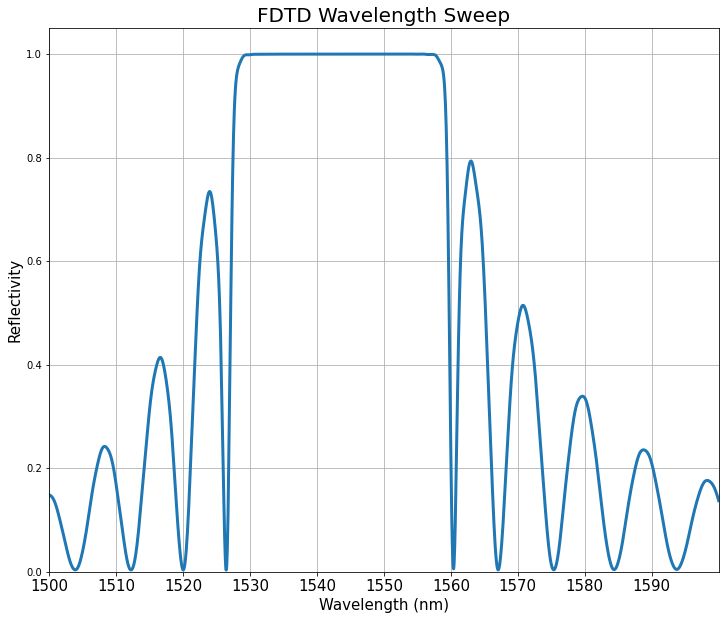

In [13]:
figure1 = plt.figure(figsize=(12,10))
plt.plot(wavelength*1e9, r, linewidth = 3)
plt.grid()
plt.xlim(1500,1600)
plt.ylim(0,1.05)
plt.title('FDTD Wavelength Sweep', size = 20)
plt.xlabel('Wavelength (nm)', size = '15')
plt.ylabel('Reflectivity', size = '15')
a, min, max = fwhm(wavelength, r, False)
#plt.plot(wavelength[min]*1e9, a, 'o',color='black')
#plt.plot(wavelength[max]*1e9, a, 'o',color='black')
#plt.plot([wavelength[min]*1e9,wavelength[max]*1e9],[r, r],linestyle='--', color = 'black')
plt.xticks(np.arange(1500,1600,step=10), size = '15')
plt.savefig('FDTD_Wavelength_Sweep')

peak, pd = find_peaks(r)
display(Math('$\Lambda_B = %5.2f nm' %(wavelength[peak[np.argmax(r[peak])]][0]*1e9)))